# 4.3 CIFAR-10データセットの転移学習【サンプルコード】

In [ ]:
# 必要なパッケージのインストール
!pip3 install torch==1.5.1+cu101
!pip3 install torchvision==0.6.1+cu101
!pip3 install numpy==1.19.0
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.10.1

     |████████████████████████████████| 14.6MB 208kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 6.9MB 3.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 4.3.1 前準備（パッケージのインポート

In [ ]:
# 必要なパッケージのインストール
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

## 4.3.2 訓練データとテストデータの用意

In [ ]:
# CIFAR10データセットの読み込み
train_dataset = torchvision.datasets.CIFAR10(root='./data/',  # データの保存場所
                                             train=True,  # 学習データかどうか
                                             download=True,  # ダウンロードするかどうか
                                             transform=transforms.Compose([
                                                 transforms.Resize(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(
                                                  [0.5, 0.5, 0.5],  # RGBの平均
                                                  [0.5, 0.5, 0.5],  # RGBの標準偏差
                                                 )
                                             ]))

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False,
                                            download=True,
                                            transform=transforms.Compose([
                                                 transforms.Resize(224),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(
                                                     [0.5, 0.5, 0.5],  # RGBの平均
                                                     # RGBの標準偏差
                                                     [0.5, 0.5, 0.5],
                                                 )
                                            ]))

# train_datasetの中身を確認
image, label = train_dataset[0]
print("image size: {}".format(image.size()))  # 画像サイズ
print("label: {}".format(label))  # ラベルサイズ

Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified
image size: torch.Size([3, 224, 224])
label: 6


In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=2)
test_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=64,
                                         shuffle=False,
                                         num_workers=2)

# ミニバッチデータセットの確認
for images, labels in train_batch:
    print("batch images size: {}".format(images.size()))  # バッチの画像サイズ
    print("image size: {}".format(images[0].size()))  # 1枚の画像サイズ
    print("batch labels size: {}".format(labels.size()))  # バッチのラベルサイズ
    break

batch images size: torch.Size([64, 3, 224, 224])
image size: torch.Size([3, 224, 224])
batch labels size: torch.Size([64])


## 4.3.3 学習済みのニューラルネットワークの読み込み

In [ ]:
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 学習済みのAlexNetを取得
net = models.alexnet(pretrained=True)
net = net.to(device)
print(net)  # AlexNetの構造を表示

cuda


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
# ニューラルネットワークのパラメータが更新されないようにする
for param in net.parameters():
    param.requires_grad = False
net = net.to(device)

In [ ]:
#出力層の出力を1000クラス用から10クラス用に変更
num_features = net.classifier[6].in_features  # 出力層の入力サイズ 
num_classes = 10  # CIFAR10のクラスの数を指定
net.classifier[6] = nn.Linear(num_features, num_classes).to(device)  # 出力を1000から2へ変更

print(net)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 4.3.4 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 4.3.5 学習

In [ ]:
# 損失と正解率を保存するリストを作成
train_loss_list = []  # 学習損失
train_accuracy_list = []  # 学習データの正答率
test_loss_list = []  # 評価損失
test_accuracy_list = []  # テストデータの正答率

# 学習（エポック）の実行
epoch = 10
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失と正解率の初期化
    train_loss = 0  # 学習損失
    train_accuracy = 0  # 学習データの正答数
    test_loss = 0  # 評価損失
    test_accuracy = 0  # テストデータの正答数

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for images, labels in train_batch:
        # GPUにTensorを転送
        images = images.to(device)
        labels = labels.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred_prob = net(images)
        # 損失（誤差）を計算
        loss = criterion(y_pred_prob, labels)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()

        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

        # 予測したラベルを予測確率y_pred_probから計算
        y_pred_labels = torch.max(y_pred_prob, 1)[1]
        # ミニバッチごとに正解したラベル数をカウント
        train_accuracy += torch.sum(y_pred_labels == labels).item()

    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_train_loss = train_loss / len(train_batch.dataset)
    epoch_train_accuracy = train_accuracy / len(train_batch.dataset)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for images, labels in test_batch:
            # GPUにTensorを転送
            images = images.to(device)
            labels = labels.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred_prob = net(images)
            # 損失（誤差）を計算
            loss = criterion(y_pred_prob, labels)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

            # 予測したラベルを予測確率y_pred_probから計算
            y_pred_labels = torch.max(y_pred_prob, 1)[1]
            # ミニバッチごとに正解したラベル数をカウント
            test_accuracy += torch.sum(y_pred_labels == labels).item()
    # エポックごとの損失と正解率を計算（ミニバッチの平均の損失と正解率を計算）
    epoch_test_loss = test_loss / len(test_batch.dataset)
    epoch_test_accuracy = test_accuracy / len(test_batch.dataset)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失と正解率を表示
    print("Train_Loss: {:.4f}, Train_Accuracy: {:.4f}".format(
        epoch_train_loss, epoch_train_accuracy))
    print("Test_Loss: {:.4f}, Test_Accuracy: {:.4f}".format(
        epoch_test_loss, epoch_test_accuracy))

    # 損失と正解率をリスト化して保存
    train_loss_list.append(epoch_train_loss)
    train_accuracy_list.append(epoch_train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_accuracy_list.append(epoch_test_accuracy)

---------------------------------------------
Epoch: 1/10
Train_Loss: 0.0138, Train_Accuracy: 0.6883
Test_Loss: 0.0107, Test_Accuracy: 0.7608
---------------------------------------------
Epoch: 2/10
Train_Loss: 0.0122, Train_Accuracy: 0.7246
Test_Loss: 0.0103, Test_Accuracy: 0.7694
---------------------------------------------
Epoch: 3/10
Train_Loss: 0.0120, Train_Accuracy: 0.7343
Test_Loss: 0.0098, Test_Accuracy: 0.7818
---------------------------------------------
Epoch: 4/10
Train_Loss: 0.0116, Train_Accuracy: 0.7404
Test_Loss: 0.0098, Test_Accuracy: 0.7792
---------------------------------------------
Epoch: 5/10
Train_Loss: 0.0116, Train_Accuracy: 0.7395
Test_Loss: 0.0103, Test_Accuracy: 0.7705
---------------------------------------------
Epoch: 6/10
Train_Loss: 0.0116, Train_Accuracy: 0.7402
Test_Loss: 0.0099, Test_Accuracy: 0.7772
---------------------------------------------
Epoch: 7/10
Train_Loss: 0.0115, Train_Accuracy: 0.7428
Test_Loss: 0.0097, Test_Accuracy: 0.7820
------

## 4.3.6 結果の可視化

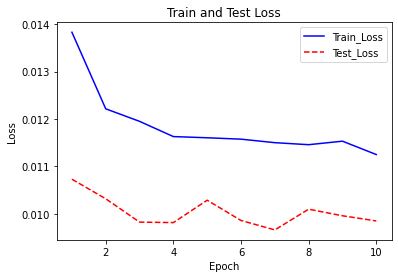

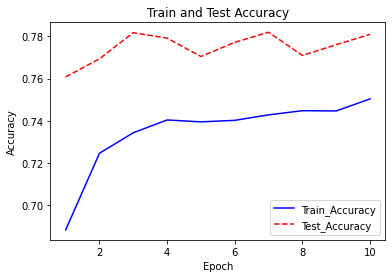

In [ ]:
# 損失
plt.figure()
plt.title('Train and Test Loss')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Loss')  # 縦軸名
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')  # Test_lossのプロット
plt.legend()  # 凡例

# 正解率
plt.figure()
plt.title('Train and Test Accuracy')  # タイトル
plt.xlabel('Epoch')  # 横軸名
plt.ylabel('Accuracy')  # 縦軸名
plt.plot(range(1, epoch+1), train_accuracy_list, color='blue',
         linestyle='-', label='Train_Accuracy')  # Train_lossのプロット
plt.plot(range(1, epoch+1), test_accuracy_list, color='red',
         linestyle='--', label='Test_Accuracy')  # Test_lossのプロット
plt.legend()

# 表示
plt.show()